In [ ]:
!unzip archive

In [ ]:
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import shutil
import pathlib

In [ ]:
import torch
from torchvision import transforms
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [ ]:
# function of set file
import torch
import os
import cv2
import matplotlib.pyplot as plt 
IMAGE_FORMAT = ["jpeg", "jpg", "png"]

def list_image_files(data_dir, sub_dir):
    image_files = []
    images_dir = os.path.join(data_dir, sub_dir)
    for file_path in os.listdir(images_dir):
        if file_path.split(".")[-1] in IMAGE_FORMAT:
            image_files.append(os.path.join(sub_dir, file_path))
    return image_files

# Road image file path
train_data_dir = "Covid19-dataset/train"
test_data_dir = "Covid19-dataset/test"
class_list = ["Normal", "Covid", "Viral Pneumonia"]

class Chest_dataset():
    def __init__(self, data_dir, transformer=None):
        self.data_dir = data_dir
        normal = list_image_files(data_dir, "Normal")
        covid = list_image_files(data_dir, "Covid")
        pneumonia = list_image_files(data_dir, "Viral Pneumonia")
        
        self.files_path = normal + covid + pneumonia
        self.transformer = transformer
        
    def __len__(self):
        return len(self.files_path)
    
    def __getitem__(self, index):
        image_file = os.path.join(self.data_dir, self.files_path[index])
        image = cv2.imread(image_file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        class_name = self.files_path[index].split(os.sep)[0]
        class_id = class_list.index(class_name)
        if self.transformer:
            image = self.transformer(image)
            class_id = torch.Tensor([class_id]).long()
        return image, class_id

In [ ]:
dset = Chest_dataset(data_dir=train_data_dir)

(1314, 1647, 3)


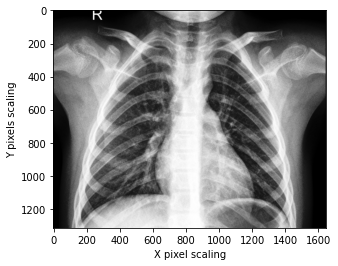

In [ ]:
image = dset[0][0]
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
print(image.shape)
plt.xlabel("X pixel scaling")
plt.ylabel("Y pixels scaling")
 
plt.imshow(image)
plt.show()

In [ ]:
train_dset = Chest_dataset(train_data_dir, transformer)

In [ ]:
from torch.utils.data import DataLoader
train_set = Chest_dataset(data_dir=train_data_dir, transformer=transformer)
train_dloader = DataLoader(train_set, batch_size=4, shuffle=True, drop_last=True)
test_set = Chest_dataset(data_dir=test_data_dir, transformer=transformer)
test_dloader = DataLoader(test_set, batch_size=4, shuffle=True, drop_last=True)

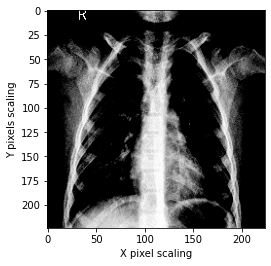

In [ ]:
image = train_set[0][0]
image = image.swapaxes(0, 1)
image = image.swapaxes(1, 2)
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

plt.xlabel("X pixel scaling")
plt.ylabel("Y pixels scaling")
 
plt.imshow(image)
plt.show()

In [ ]:
import torch.nn as nn
import torch.nn.functional as F 
class basicCNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3,5,3)
    self.maxpool = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(5,16,3)
    self.fc1 = nn.Linear(16 * 54 * 54, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 3)
  
  def forward(self,x):
    x = self.maxpool(F.relu(self.conv1(x)))
    x = self.maxpool(F.relu(self.conv2(x)))
    x = torch.flatten(x, 1) # flatten all dimensions except batch
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

model = basicCNN()
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
from torchsummary import summary
import torch
summary(model,(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 5, 222, 222]             140
         MaxPool2d-2          [-1, 5, 111, 111]               0
            Conv2d-3         [-1, 16, 109, 109]             736
         MaxPool2d-4           [-1, 16, 54, 54]               0
            Linear-5                  [-1, 120]       5,598,840
            Linear-6                   [-1, 84]          10,164
            Linear-7                    [-1, 3]             255
Total params: 5,610,135
Trainable params: 5,610,135
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 4.16
Params size (MB): 21.40
Estimated Total Size (MB): 26.13
----------------------------------------------------------------


In [ ]:
epochs = 20
lossList = []
accList = []
for epoch in range(epochs):  # loop over the dataset multiple times

    epochs_acc = 0.0
    epochs_loss = 0.0
    for inputs,labels in tqdm(train_dloader):
        # get the inputs; data is a list of [inputs, labels]
        # inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        labels = labels.reshape(1,-1)
        loss = criterion(outputs, labels[0])
        _, pred = torch.max(outputs, 1)
        loss.backward()
        optimizer.step()

        # print statistics
        epochs_acc += torch.sum(pred == labels)
        epochs_loss += loss.item() * len(outputs)
    data_size = len(train_dloader.dataset)
    epochs_loss = epochs_loss / data_size
    epochs_acc = epochs_acc.double() / data_size
    lossList.append(epochs_loss)
    accList.append(epochs_acc)
    print(f'Epoch {epoch + 1}/{epochs} | Loss: {epochs_loss:.4f} | Acc: {epochs_acc:.4f}')

print('Finished Training')

100%|██████████| 62/62 [00:21<00:00,  2.83it/s]


Epoch 1/20 | Loss: 1.0284 | Acc: 0.4542


100%|██████████| 62/62 [00:22<00:00,  2.81it/s]


Epoch 2/20 | Loss: 0.5705 | Acc: 0.7649


100%|██████████| 62/62 [00:21<00:00,  2.83it/s]


Epoch 3/20 | Loss: 0.3509 | Acc: 0.8446


100%|██████████| 62/62 [00:22<00:00,  2.73it/s]


Epoch 4/20 | Loss: 0.3701 | Acc: 0.8606


100%|██████████| 62/62 [00:21<00:00,  2.85it/s]


Epoch 5/20 | Loss: 0.2539 | Acc: 0.9084


100%|██████████| 62/62 [00:21<00:00,  2.87it/s]


Epoch 6/20 | Loss: 0.1308 | Acc: 0.9363


100%|██████████| 62/62 [00:21<00:00,  2.89it/s]


Epoch 7/20 | Loss: 0.1770 | Acc: 0.9243


100%|██████████| 62/62 [00:21<00:00,  2.88it/s]


Epoch 8/20 | Loss: 0.1437 | Acc: 0.9323


100%|██████████| 62/62 [00:21<00:00,  2.86it/s]


Epoch 9/20 | Loss: 0.1029 | Acc: 0.9522


100%|██████████| 62/62 [00:21<00:00,  2.90it/s]


Epoch 10/20 | Loss: 0.0586 | Acc: 0.9681


100%|██████████| 62/62 [00:21<00:00,  2.88it/s]


Epoch 11/20 | Loss: 0.0958 | Acc: 0.9482


100%|██████████| 62/62 [00:21<00:00,  2.86it/s]


Epoch 12/20 | Loss: 0.0428 | Acc: 0.9761


100%|██████████| 62/62 [00:22<00:00,  2.81it/s]


Epoch 13/20 | Loss: 0.0125 | Acc: 0.9880


100%|██████████| 62/62 [00:22<00:00,  2.78it/s]


Epoch 14/20 | Loss: 0.0170 | Acc: 0.9801


100%|██████████| 62/62 [00:23<00:00,  2.61it/s]


Epoch 15/20 | Loss: 0.0094 | Acc: 0.9880


100%|██████████| 62/62 [00:23<00:00,  2.67it/s]


Epoch 16/20 | Loss: 0.0296 | Acc: 0.9801


100%|██████████| 62/62 [00:23<00:00,  2.66it/s]


Epoch 17/20 | Loss: 0.0076 | Acc: 0.9841


100%|██████████| 62/62 [00:23<00:00,  2.64it/s]


Epoch 18/20 | Loss: 0.0023 | Acc: 0.9880


100%|██████████| 62/62 [00:23<00:00,  2.65it/s]


Epoch 19/20 | Loss: 0.0039 | Acc: 0.9880


100%|██████████| 62/62 [00:23<00:00,  2.65it/s]

Epoch 20/20 | Loss: 0.0015 | Acc: 0.9880
Finished Training


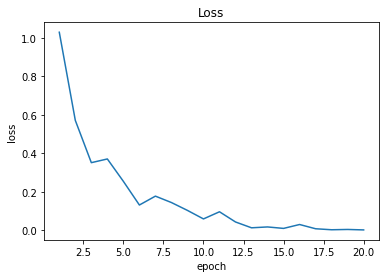

In [ ]:
x = list(range(1,21))
plt.title("Loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(x,lossList)

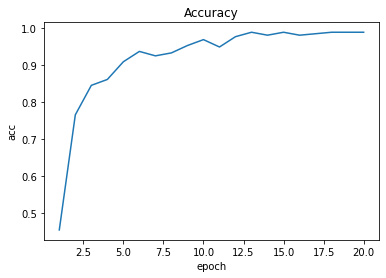

In [ ]:
x = list(range(1,21))
plt.title("Accuracy")
plt.xlabel("epoch")
plt.ylabel("acc")
plt.plot(x,accList)

In [ ]:
with torch.no_grad():
  for inputs,labels in tqdm(test_dloader):
        # get the inputs; data is a list of [inputs, labels]
        # inputs, labels = data
        # zero the parameter gradients

        # forward + backward + optimize
        outputs = model(inputs)
        labels = labels.reshape(1,-1)
        loss = criterion(outputs, labels[0])
        _, pred = torch.max(outputs, 1)

        # print statistics
        epochs_acc += torch.sum(pred == labels)
        epochs_loss += loss.item() * len(outputs)
  data_size = len(test_dloader.dataset)
  epochs_loss = epochs_loss / data_size
  epochs_acc = epochs_acc.double() / data_size
  print(f'Epoch {epoch + 1}/{epochs} | Loss: {epochs_loss:.4f} | Acc: {epochs_acc:.4f}')

100%|██████████| 16/16 [00:02<00:00,  5.68it/s]

Epoch 20/20 | Loss: 0.7594 | Acc: 0.8635
